In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
sc = spark.sparkContext

### Read the Data:

In [0]:
data = sc.textFile( "/FileStore/tables/customerdata.csv" )
data.take(10)

Out[68]: ['1,41100,48.75',
 '2,54100,28.1',
 '3,47800,46.75',
 '4,19100,40.25',
 '5,18200,35.8',
 '6,19800,41.45',
 '7,51500,31.55',
 '8,39900,48.2',
 '9,13000,36.8',
 '10,31900,43.05']

In [0]:
from collections import namedtuple

Customer = namedtuple('Customer', ['CustID', 'Income', 'Age'])

In [0]:
def getRec(line):
    line= line.split(',')
    try:
        return Customer(line[0], int(line[1]),float(line[2]))
    except:
        return None

#### Format the data:

In [0]:
cust_recs = data.map(lambda line: getRec(line))
cust_recs.take(10)

Out[71]: [Customer(CustID='1', Income=41100, Age=48.75),
 Customer(CustID='2', Income=54100, Age=28.1),
 Customer(CustID='3', Income=47800, Age=46.75),
 Customer(CustID='4', Income=19100, Age=40.25),
 Customer(CustID='5', Income=18200, Age=35.8),
 Customer(CustID='6', Income=19800, Age=41.45),
 Customer(CustID='7', Income=51500, Age=31.55),
 Customer(CustID='8', Income=39900, Age=48.2),
 Customer(CustID='9', Income=13000, Age=36.8),
 Customer(CustID='10', Income=31900, Age=43.05)]

In [0]:
cust_recs = cust_recs.filter(lambda x: x is not None)

In [0]:
cust_recs.take(10)

Out[73]: [Customer(CustID='1', Income=41100, Age=48.75),
 Customer(CustID='2', Income=54100, Age=28.1),
 Customer(CustID='3', Income=47800, Age=46.75),
 Customer(CustID='4', Income=19100, Age=40.25),
 Customer(CustID='5', Income=18200, Age=35.8),
 Customer(CustID='6', Income=19800, Age=41.45),
 Customer(CustID='7', Income=51500, Age=31.55),
 Customer(CustID='8', Income=39900, Age=48.2),
 Customer(CustID='9', Income=13000, Age=36.8),
 Customer(CustID='10', Income=31900, Age=43.05)]

#### Normalising the Data:

In [0]:
min_sal = cust_recs.map(lambda rec: rec.Income).reduce(min)
max_sal = cust_recs.map(lambda rec: rec.Income).reduce(max)
min_age = cust_recs.map(lambda rec: rec.Age).reduce(min)
max_age = cust_recs.map(lambda rec: rec.Age).reduce(max)

In [0]:
min_sal, max_sal

Out[75]: (3100, 60200)

In [0]:
min_age, max_age

Out[76]: (26.7, 50.4)

In [0]:
min_max_vals = sc.broadcast( { "min_sal": min_sal, "max_sal": max_sal, "min_age": min_age, "max_age": max_age } )

In [0]:
min_max_vals.value

Out[78]: {'min_sal': 3100, 'max_sal': 60200, 'min_age': 26.7, 'max_age': 50.4}

In [0]:
import random
def normalize(rec):
    sal_range = min_max_vals.value['max_sal'] - min_max_vals.value['min_sal']
    age_range = min_max_vals.value['max_age'] - min_max_vals.value['min_age']    
    sal = float((rec.Income - min_max_vals.value['min_sal'])/sal_range)
    age = float((rec.Age -min_max_vals.value['min_age'])/age_range)
    return ( rec.CustID, sal, age, 1.0 )

#### Normalised Data:

In [0]:
NormalisedData= cust_recs.map(lambda a: normalize(a))
NormalisedData.take(10)

Out[80]: [('1', 0.6654991243432574, 0.9303797468354431, 1.0),
 ('2', 0.8931698774080561, 0.059071729957806, 1.0),
 ('3', 0.7828371278458844, 0.8459915611814347, 1.0),
 ('4', 0.28021015761821366, 0.5717299578059072, 1.0),
 ('5', 0.26444833625218916, 0.3839662447257383, 1.0),
 ('6', 0.29246935201401053, 0.6223628691983124, 1.0),
 ('7', 0.8476357267950964, 0.20464135021097052, 1.0),
 ('8', 0.6444833625218914, 0.9071729957805909, 1.0),
 ('9', 0.1733800350262697, 0.4261603375527425, 1.0),
 ('10', 0.5043782837127846, 0.6898734177215189, 1.0)]

### Clustering:

In [0]:
def getsum(x, y):
    return (0, x[1] + y[1], x[2] + y[2], x[3] + y[3])

In [0]:
def findCentroids(cl):
    centroids_sums = cl.reduceByKey(getsum)
    centroids = centroids_sums.map(lambda a:(a[0], (a[1][1]/a[1][3],a[1][2]/a[1][3])))
    return centroids

In [0]:
from math import dist
dist((0.6278557232531142, 0.4717441805338266), (0.635262160906394, 0.5154783432360286))

Out[83]: 0.044356874393656216

In [0]:
def updateClusters(a):
    di = dist(z.value[0][1],(a[1], a[2]))
    c = z.value[0][0]

    next_dist = dist(z.value[1][1],(a[1], a[2]))

    if next_dist < di:
        c = z.value[1][0]
        di = next_dist

    next_dist = dist(z.value[2][1],(a[1], a[2]))

    if next_dist < di:
        c = z.value[2][0]
        di = next_dist

    next_dist = dist(z.value[3][1],(a[1], a[2]))

    if next_dist < di:
        c = z.value[3][0]

    return (c,a)

In [0]:
NormalisedData = cust_recs.map(lambda a: normalize(a))
NormalisedData.take(10)

Out[85]: [('1', 0.6654991243432574, 0.9303797468354431, 1.0),
 ('2', 0.8931698774080561, 0.059071729957806, 1.0),
 ('3', 0.7828371278458844, 0.8459915611814347, 1.0),
 ('4', 0.28021015761821366, 0.5717299578059072, 1.0),
 ('5', 0.26444833625218916, 0.3839662447257383, 1.0),
 ('6', 0.29246935201401053, 0.6223628691983124, 1.0),
 ('7', 0.8476357267950964, 0.20464135021097052, 1.0),
 ('8', 0.6444833625218914, 0.9071729957805909, 1.0),
 ('9', 0.1733800350262697, 0.4261603375527425, 1.0),
 ('10', 0.5043782837127846, 0.6898734177215189, 1.0)]

In [0]:
z = sc.broadcast([(0, (0.1, 0.1)), (1, (0.4, 0.4)), (2, (0.8, 0.8)),(4, (0.3, 0.3))])

In [0]:
z.value[1][1]

Out[87]: (0.4, 0.4)

In [0]:
NormalisedData.take(10)

Out[88]: [('1', 0.6654991243432574, 0.9303797468354431, 1.0),
 ('2', 0.8931698774080561, 0.059071729957806, 1.0),
 ('3', 0.7828371278458844, 0.8459915611814347, 1.0),
 ('4', 0.28021015761821366, 0.5717299578059072, 1.0),
 ('5', 0.26444833625218916, 0.3839662447257383, 1.0),
 ('6', 0.29246935201401053, 0.6223628691983124, 1.0),
 ('7', 0.8476357267950964, 0.20464135021097052, 1.0),
 ('8', 0.6444833625218914, 0.9071729957805909, 1.0),
 ('9', 0.1733800350262697, 0.4261603375527425, 1.0),
 ('10', 0.5043782837127846, 0.6898734177215189, 1.0)]

In [0]:
cl = NormalisedData.map(lambda a: updateClusters(a))

In [0]:
cl.take(1)

Out[90]: [(2, ('1', 0.6654991243432574, 0.9303797468354431, 1.0))]

In [0]:
cl.count()

Out[91]: 300

In [0]:
cl.take(10)

Out[92]: [(2, ('1', 0.6654991243432574, 0.9303797468354431, 1.0)),
 (1, ('2', 0.8931698774080561, 0.059071729957806, 1.0)),
 (2, ('3', 0.7828371278458844, 0.8459915611814347, 1.0)),
 (1, ('4', 0.28021015761821366, 0.5717299578059072, 1.0)),
 (4, ('5', 0.26444833625218916, 0.3839662447257383, 1.0)),
 (1, ('6', 0.29246935201401053, 0.6223628691983124, 1.0)),
 (1, ('7', 0.8476357267950964, 0.20464135021097052, 1.0)),
 (2, ('8', 0.6444833625218914, 0.9071729957805909, 1.0)),
 (4, ('9', 0.1733800350262697, 0.4261603375527425, 1.0)),
 (1, ('10', 0.5043782837127846, 0.6898734177215189, 1.0))]

In [0]:
centroids= findCentroids(cl)

print(centroids.take(3))

[(2, (0.7248357059874114, 0.8453440280736934)), (4, (0.18842072731018852, 0.4139364606602135)), (0, (0.18563922942206657, 0.1740506329113925))]


In [0]:
numIter=15 #number of iterations

z = sc.broadcast([(0, (0.1, 0.4)), (2, (0.4, 0.1)), (1, (0.6, 0.4)),  (4, (0.3, 0.3))])

NormalisedData = cust_recs.map(lambda a: normalize(a))

for i in range(numIter):
    cl = NormalisedData.map(lambda a: updateClusters(a))
    centroids = findCentroids(cl)
    print("Centroids after iteration: {}".format(i+1))
    print(centroids.take(3))
    z.unpersist()
    z = sc.broadcast(centroids.collect())
    print('########################')

Centroids after iteration: 1
[(0, (0.18439310251919705, 0.5630882830249919)), (4, (0.3021432741222584, 0.43801486839461523)), (2, (0.3677758318739054, 0.13818565400843885))]
########################
Centroids after iteration: 2
[(0, (0.21496514542769823, 0.6109456440804172)), (4, (0.32434325744308234, 0.4844936708860759)), (2, (0.33800350262697026, 0.18957203134418327))]
########################
Centroids after iteration: 3
[(0, (0.22238032691185053, 0.6309335443037976)), (4, (0.3350581117656425, 0.5026850786344457)), (2, (0.287215411558669, 0.21026722925457111))]
########################
Centroids after iteration: 4
[(0, (0.22333054138429909, 0.6369014859658779)), (4, (0.33130959330609067, 0.5060009376465072)), (2, (0.2819614711033275, 0.22278481012658236))]
########################
Centroids after iteration: 5
[(4, (0.33084596055737453, 0.5140341221794166)), (0, (0.2215615199771922, 0.6434599156118145)), (2, (0.2713076474022183, 0.24841772151898742))]
########################
Centroi

In [0]:
cl.take(10)

Out[95]: [(0, ('1', 0.6654991243432574, 0.9303797468354431, 1.0)),
 (1, ('2', 0.8931698774080561, 0.059071729957806, 1.0)),
 (0, ('3', 0.7828371278458844, 0.8459915611814347, 1.0)),
 (4, ('4', 0.28021015761821366, 0.5717299578059072, 1.0)),
 (2, ('5', 0.26444833625218916, 0.3839662447257383, 1.0)),
 (4, ('6', 0.29246935201401053, 0.6223628691983124, 1.0)),
 (1, ('7', 0.8476357267950964, 0.20464135021097052, 1.0)),
 (0, ('8', 0.6444833625218914, 0.9071729957805909, 1.0)),
 (2, ('9', 0.1733800350262697, 0.4261603375527425, 1.0)),
 (4, ('10', 0.5043782837127846, 0.6898734177215189, 1.0))]

In [0]:
final_cl = cl.map(lambda rec: (rec[1][0], rec[0]))

In [0]:
final_cl.take(10)

Out[97]: [('1', 0),
 ('2', 1),
 ('3', 0),
 ('4', 4),
 ('5', 2),
 ('6', 4),
 ('7', 1),
 ('8', 0),
 ('9', 2),
 ('10', 4)]

In [0]:
cust_recs_with_cluster = cust_recs.map(lambda rec: (rec.CustID, (rec.Age, rec.Income))).join(final_cl)

#### Final Data with Clusters:

In [0]:
cust_recs_with_cluster.take(10)

Out[99]: [('4', ((40.25, 19100), 4)),
 ('10', ((43.05, 31900), 4)),
 ('12', ((29.25, 56700), 1)),
 ('16', ((41.15, 18200), 4)),
 ('20', ((29.0, 53200), 1)),
 ('24', ((47.3, 41200), 0)),
 ('26', ((38.95, 13200), 4)),
 ('40', ((30.1, 52400), 1)),
 ('44', ((28.0, 53900), 1)),
 ('50', ((28.35, 54400), 1))]

In [0]:
cust_recs_with_cluster_v1 = cust_recs_with_cluster.map(lambda rec: (rec[0], 
                                                                    rec[1][0][0], 
                                                                    rec[1][0][1], 
                                                                    rec[1][1]))

In [0]:
cust_recs_with_cluster_v1.take(10)

Out[101]: [('4', 40.25, 19100, 4),
 ('10', 43.05, 31900, 4),
 ('12', 29.25, 56700, 1),
 ('16', 41.15, 18200, 4),
 ('20', 29.0, 53200, 1),
 ('24', 47.3, 41200, 0),
 ('26', 38.95, 13200, 4),
 ('40', 30.1, 52400, 1),
 ('44', 28.0, 53900, 1),
 ('50', 28.35, 54400, 1)]

### Data into Dataframe and Analysis:

In [0]:
import pandas as pd

In [0]:
cust_cluster_list=cust_recs_with_cluster_v1.collect()
cust_cluster_df=pd.DataFrame(cust_cluster_list, columns=['CustID', 'Age', 'Income', 'ClusterID'])

In [0]:
cust_cluster_df.head()

,CustID,Age,Income,ClusterID
0,4,40.25,19100,4
1,10,43.05,31900,4
2,12,29.25,56700,1
3,16,41.15,18200,4
4,20,29.00,53200,1


In [0]:
cust_cluster_df.groupby("ClusterID")["Age", 'Income'].mean()

<command-839471063242672>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cust_cluster_df.groupby("ClusterID")["Age", 'Income'].mean()


,Age,Income
ClusterID,,
0,46.662255,44430.392157
1,29.384000,55204.000000
2,35.636111,16455.555556
4,41.237903,19624.193548


In [0]:
cust_cluster_df.groupby("ClusterID")["Age", 'Income'].median()

<command-839471063242673>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cust_cluster_df.groupby("ClusterID")["Age", 'Income'].median()


,Age,Income
ClusterID,,
0,46.725,44350.0
1,29.375,55200.0
2,36.500,16750.0
4,40.550,19900.0


In [0]:
cust_cluster_df.groupby("ClusterID")["Age", 'Income'].std()

<command-839471063242674>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cust_cluster_df.groupby("ClusterID")["Age", 'Income'].std()


,Age,Income
ClusterID,,
0,2.132393,4233.945547
1,0.921458,1951.943864
2,2.635408,6525.573623
4,2.115898,7090.531333


In [0]:
cust_cluster_df[["Age", 'Income']].describe()

,Age,Income
count,300.000000,300.000000
mean,38.458667,39538.000000
std,7.523574,16099.214422
min,26.700000,3100.000000
25%,29.937500,24800.000000
50%,39.525000,44450.000000
75%,45.650000,54125.000000
max,50.400000,60200.000000


#### Plotting the Clusters

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

Out[110]: <AxesSubplot:xlabel='Age', ylabel='Income'>

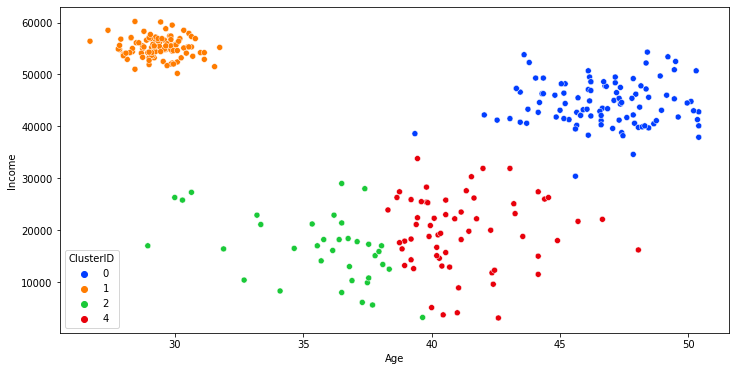

In [0]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=cust_cluster_df, x='Age', y='Income', hue='ClusterID', palette='bright')